# A model of investor sentiment

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [144]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

**Model setup**

The purpose of this model is to understand how a representative rational investor operates on the stock market, given a wrong idea of the true model of the assets.

_**True model of dividend earnings**_

Earnings at time $t$: $N_t = N_{t-1}+y_t\\$ 
Where $y_t$ is a random shock to earnings that can take two values, $y$ and $-y$ with equal probability


_**The model investor believes**_

Investor believes the shocks in two consecutive periods to be correlated.\
The correlation can be negative (Mean reversion) or positive (momentum)\
The two models can be described by:

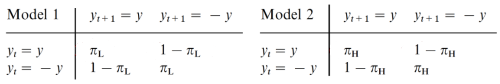

Assume $\pi_L < \frac{1}{2} < \pi_H$

Such that if investor believes in model 1, a positive shock in $y_{t+1}$ is less likely after a positive shock in $y$\
If investor believes in model 2, a positive shock in $y_{t+1}$ is more likely after a positive shock in $y$

If investor believes in model 1, he reacts too little to individual earnings announcements that creates a positive shock, as he expects a negative shock in the following period.\
Conversely, if he believes in model 2, he reacts too strongly to strings of positive shocks, as he expects the positive shocks to continue.

_Model switching_

Investor believes in two states of the world:\
$s_t = 1$: Earnings shock in $y_t$ is generated by model 1\
$s_t = 2$: Earnings shock in $y_t$ is generated by model 2

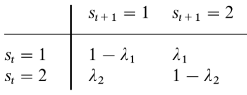

Assume $\lambda_1+\lambda_2 < 1$ (regime switch is rare)

_**Investor's earnings forecast**_

Investor observes earnings in each period and tries to understand which model is currently governing earnings.\
In the following, investor observes $y_{t+1}$ and calculates the probability $q_{t+1}$ = probability that model 1 generated the earnings.\
$q_{t+1}=P(s_{t+1}=1 | y_{t+1},y_t,q_t)$

$q_{t+1}=\frac{P(y_{t+1}|y_t,s_{t+1}=1)*P(s_{t+1}=1)}{P(y_{t+1}|y_t,s_{t+1}=1)*P(s_{t+1}=1)+P(y_{t+1}|y_t,s_{t+1}=2)*P(s_{t+1}=2)}$

Where:\
$P(s_{t+1}=1)=(1-\lambda_1)q_t + \lambda_2(1-q_t)$\
$P(s_{t+1}=2)=\lambda_1q_t + (1-\lambda_2)(1-q_t)$


_Shocks with same sign in t and t+1_\
$P(y_{t+1}=y|y_t=y,s_{t+1}=1)=P(y_{t+1}=-y|y_t=-y,s_{t+1}=1)=\pi_L$\
$P(y_{t+1}=y|y_t=y,s_{t+1}=2)=P(y_{t+1}=-y|y_t=-y,s_{t+1}=2)=\pi_H$

$q_{t+1}=\frac{\pi_L[(1-\lambda_1)q_t+\lambda_2(1-q_t)]}{\pi_L[(1-\lambda_1)q_t+\lambda_2(1-q_t)]+\pi_H[\lambda_1q_t+(1-\lambda_2)(1-q_t)]}$
\
\
\
\
_Shocks with opposite sign in t and t+1_\
$P(y_{t+1}=y|y_t=-y,s_{t+1}=1)=P(y_{t+1}=-y|y_t=y,s_{t+1}=1)=1-\pi_L$\
$P(y_{t+1}=y|y_t=-y,s_{t+1}=2)=P(y_{t+1}=-y|y_t=y,s_{t+1}=2)=1-\pi_H$

$q_{t+1}=\frac{(1-\pi_L)[(1-\lambda_1)q_t+\lambda_2(1-q_t)]}{(1-\pi_L)[(1-\lambda_1)q_t+\lambda_2(1-q_t)]+(1-\pi_H)[\lambda_1q_t+(1-\lambda_2)(1-q_t)]}$

## Numerical solution

In [156]:
from modelproject import InvestorForecast
model = InvestorForecast()
par = model.par
np.random.seed(2000)
state = np.random.get_state()

Initial parameters are defined in the .py file to be:\
$\pi_L = 0.4$\
$\pi_H = 0.6$\
$\lambda_1 = 0.4$\
$\lambda_2 = 0.4$\
$q_t = 0.5$

**Investor's forecast**

_Proof of concept_

In [146]:
print(f'Probability that model 1 governs earnings in period t+1 when two identical shocks hit: {model.forecast(1,1,par.q_ini):.2f}')
print(f'Probability that model 1 governs earnings in period t+1 when two oppostite shocks hit: {model.forecast(1,-1,par.q_ini):.2f}')

Probability that model 1 governs earnings in period t+1 when two identical shocks hit: 0.40
Probability that model 1 governs earnings in period t+1 when two oppostite shocks hit: 0.60


The investor's perceived probability that model 1 governs earnings increases as shocks changes signs

**Convergence given consecutive shocks with same sign**

In the following, $q_{t+1}$ will be saved as _q_ for the consecutive period.

Iteration	q		new_q
1		0.500000	0.400000
2		0.400000	0.380952
3		0.380952	0.377358
4		0.377358	0.376682
5		0.376682	0.376554
6		0.376554	0.376530
7		0.376530	0.376526
8		0.376526	0.376525


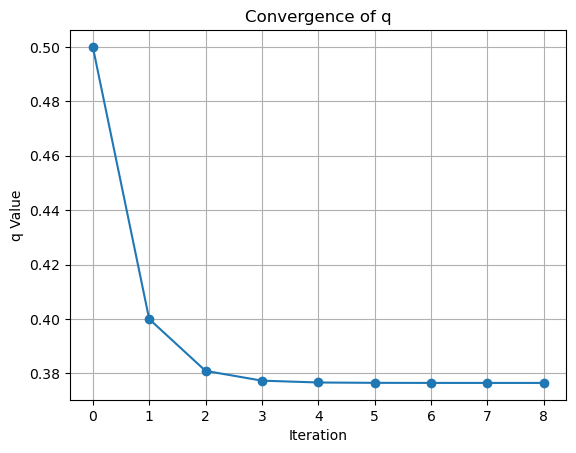

In [147]:
model.convergence(1,1);

Given the initial parameters and consecutive positive shocks to $y_t$, investor will believe model 1 governs earnings at probability 0.38 after 8 periods

**Convergence given consecutive alternating shocks**

Iteration	q		new_q
1		0.500000	0.600000
2		0.600000	0.619048
3		0.619048	0.622642
4		0.622642	0.623318
5		0.623318	0.623446
6		0.623446	0.623470
7		0.623470	0.623474
8		0.623474	0.623475


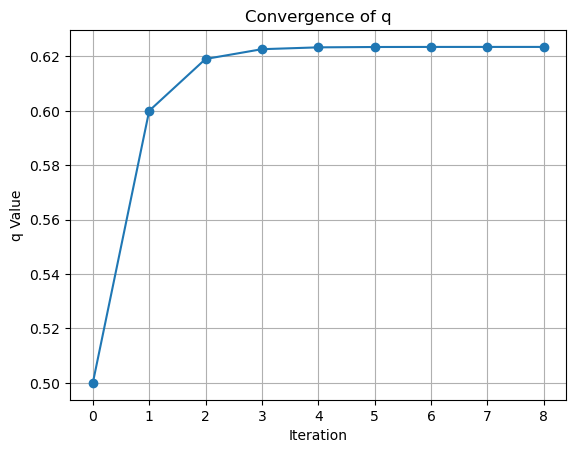

In [148]:
model.convergence(1,-1);

Given the initial parameters and consecutive alternating shocks to $y_t$, investor will believe model 1 governs earnings at probability 0.62 after 8 periods

**Plot of the first 20 periods with randomly distributed shocks**

Period  1: old_y =  1, new_y = -1, q = 0.60
Period  2: old_y = -1, new_y = -1, q = 0.42
Period  3: old_y = -1, new_y = -1, q = 0.38
Period  4: old_y = -1, new_y =  1, q = 0.58
Period  5: old_y =  1, new_y = -1, q = 0.61
Period  6: old_y = -1, new_y =  1, q = 0.62
Period  7: old_y =  1, new_y = -1, q = 0.62
Period  8: old_y = -1, new_y = -1, q = 0.42
Period  9: old_y = -1, new_y = -1, q = 0.39
Period 10: old_y = -1, new_y = -1, q = 0.38
Period 11: old_y = -1, new_y =  1, q = 0.58
Period 12: old_y =  1, new_y = -1, q = 0.61
Period 13: old_y = -1, new_y = -1, q = 0.42
Period 14: old_y = -1, new_y =  1, q = 0.58
Period 15: old_y =  1, new_y =  1, q = 0.42
Period 16: old_y =  1, new_y = -1, q = 0.58
Period 17: old_y = -1, new_y =  1, q = 0.62
Period 18: old_y =  1, new_y =  1, q = 0.42
Period 19: old_y =  1, new_y = -1, q = 0.59
Period 20: old_y = -1, new_y = -1, q = 0.42


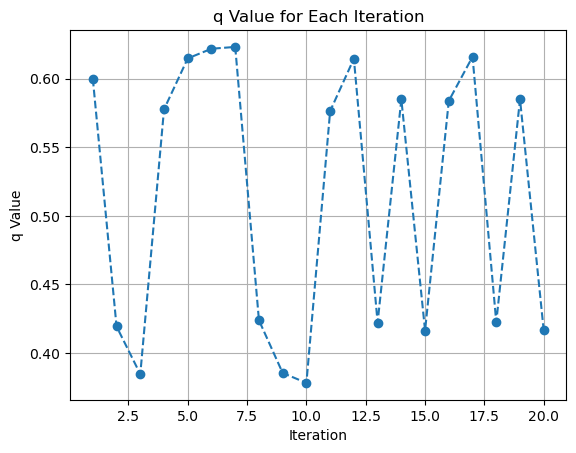

In [176]:
n = 20  # Number of periods
np.random.set_state(state)
ini_sim = model.simulate(n)

Given initial parameters, the representative investor is relatively quick to believe in a regime change, while he will at most believe in a specific model to govern earnings with probability 62% 

# Further analysis

Now I want to investigate what happens to the convergence rate and steady state value when changing parameter values\
Recall, small $\pi_L$ means investor believes two consecutive shocks with the same sign are less likely, given model 1.\
A large $\pi_H$ means investor believes two consecutive shocks with the same sign are more likely given model 2.\
Higher $\lambda$ values indicate a stronger belief in regime changes


In [182]:
# Defining parameter value ranges
pi_L_values = np.arange(0.05, 0.5, 0.05)
pi_H_values = np.arange(0.5, 1.0, 0.05)

lam_1_values = np.arange(0.05, 0.5, 0.05)
lam_2_values = np.arange(0.05, 0.5, 0.05)

**"All else equal"-convergence given consecutive shocks with same sign**

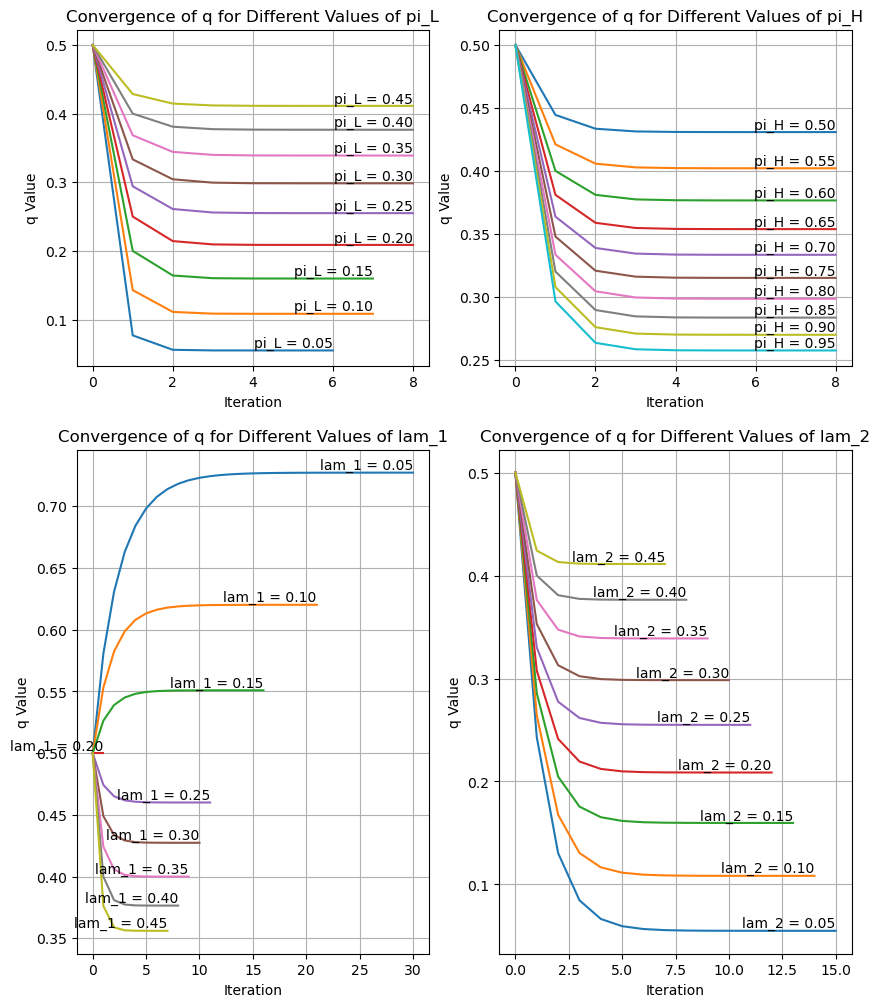

In [183]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 12), gridspec_kw={'height_ratios': [2, 3]})

convergence_results_pi_L_same = []
convergence_results_pi_H_same = []
convergence_results_lam_1_same = []
convergence_results_lam_2_same = []

# Plot for pi_L
ax1.set_xlabel('Iteration')
ax1.set_ylabel('q Value')
ax1.set_title('Convergence of q for Different Values of pi_L')
ax1.grid(True)

for pi_L in pi_L_values:
    investor = InvestorForecast()
    investor.par.pi_L = pi_L
    q_values_pi_L = investor.convergence(1, 1, False)
    convergence_results_pi_L_same.append((pi_L, q_values_pi_L))
    ax1.plot(q_values_pi_L, label=f'pi_L = {pi_L}')
    ax1.text(len(q_values_pi_L) - 1, q_values_pi_L[-1], f'pi_L = {pi_L:.2f}', verticalalignment='bottom', horizontalalignment='right')

# Plot for pi_H
ax2.set_xlabel('Iteration')
ax2.set_ylabel('q Value')
ax2.set_title('Convergence of q for Different Values of pi_H')
ax2.grid(True)

for pi_H in pi_H_values:
    investor = InvestorForecast()
    investor.par.pi_H = pi_H
    q_values_pi_H = investor.convergence(1, 1, False)
    convergence_results_pi_H_same.append((pi_H, q_values_pi_H))
    ax2.plot(q_values_pi_H, label=f'pi_H = {pi_H}')
    ax2.text(len(q_values_pi_H) - 1, q_values_pi_H[-1], f'pi_H = {pi_H:.2f}', verticalalignment='bottom', horizontalalignment='right')

# Plot for lam_1
ax3.set_xlabel('Iteration')
ax3.set_ylabel('q Value')
ax3.set_title('Convergence of q for Different Values of lam_1')
ax3.grid(True)

for lam_1 in lam_1_values:
    investor = InvestorForecast()
    investor.par.lam_1 = lam_1
    q_values_lam_1 = investor.convergence(1, 1, False)
    convergence_results_lam_1_same.append((lam_1, q_values_lam_1))
    ax3.plot(q_values_lam_1, label=f'lam_1 = {lam_1}')
    ax3.text(len(q_values_lam_1) - 1, q_values_lam_1[-1], f'lam_1 = {lam_1:.2f}', verticalalignment='bottom', horizontalalignment='right')

# Plot for lam_2
ax4.set_xlabel('Iteration')
ax4.set_ylabel('q Value')
ax4.set_title('Convergence of q for Different Values of lam_2')
ax4.grid(True)

for lam_2 in lam_2_values:
    investor = InvestorForecast()
    investor.par.lam_2 = lam_2
    q_values_lam_2 = investor.convergence(1, 1, False)
    convergence_results_lam_2_same.append((lam_2, q_values_lam_2))
    ax4.plot(q_values_lam_2, label=f'lam_2 = {lam_2}')
    ax4.text(len(q_values_lam_2) - 1, q_values_lam_2[-1], f'lam_2 = {lam_2:.2f}', verticalalignment='bottom', horizontalalignment='right')


plt.show()

_Changes in_ $\pi_L$\
A smaller value of $\pi_L$ indicates a small perceived probability of consecutive similar shocks happening, given model 1.\
Therefore, when $\pi_L$ is small and many consecutive shocks happen, investor, all else equal, perceives model 1 to be less likely.\
Also, he converges to this result faster than if $\pi_L$ is larger.\
\
_Changes in_ $\pi_H$\
A larger value of $\pi_H$ indicates a larger perceived probability of consecutive similar shocks happening, given model 2.\
Therefore, when $\pi_H$ is large and many consecutive shocks happen, investor, all else equal, perceives model 1 to be less likely.\
\
_Changes in_ $\lambda_1$\
A smaller value of $\lambda_1$ indicates a larger perceived probability of $s_t=s_{t+1}=1$, where model 1 governs earnings\
Therefore, when $\lambda_1$ is small and many consecutive shocks happen, investor, all else equal, perceives model 1 to be more likely than if $\lambda_1$ is large\
Investor will take a longer time to converge to this result, than if $\lambda_1$ was larger.\
\
_Changes in_ $\lambda_2$\
A smaller value of $\lambda_2$ indicates a larger perceived probability of $s_t=s_{t+1}=2$, where model 2 governs earnings\
Therefore, when $\lambda_2$ is small and many consecutive shocks happen, investor, all else equal, perceives model 1 to be less likely than if $\lambda_2$ is large\
Investor will take a longer time to converge to this result, than if $\lambda_2$ was larger.

**"All else equal"-convergence given consecutive alternating shocks**

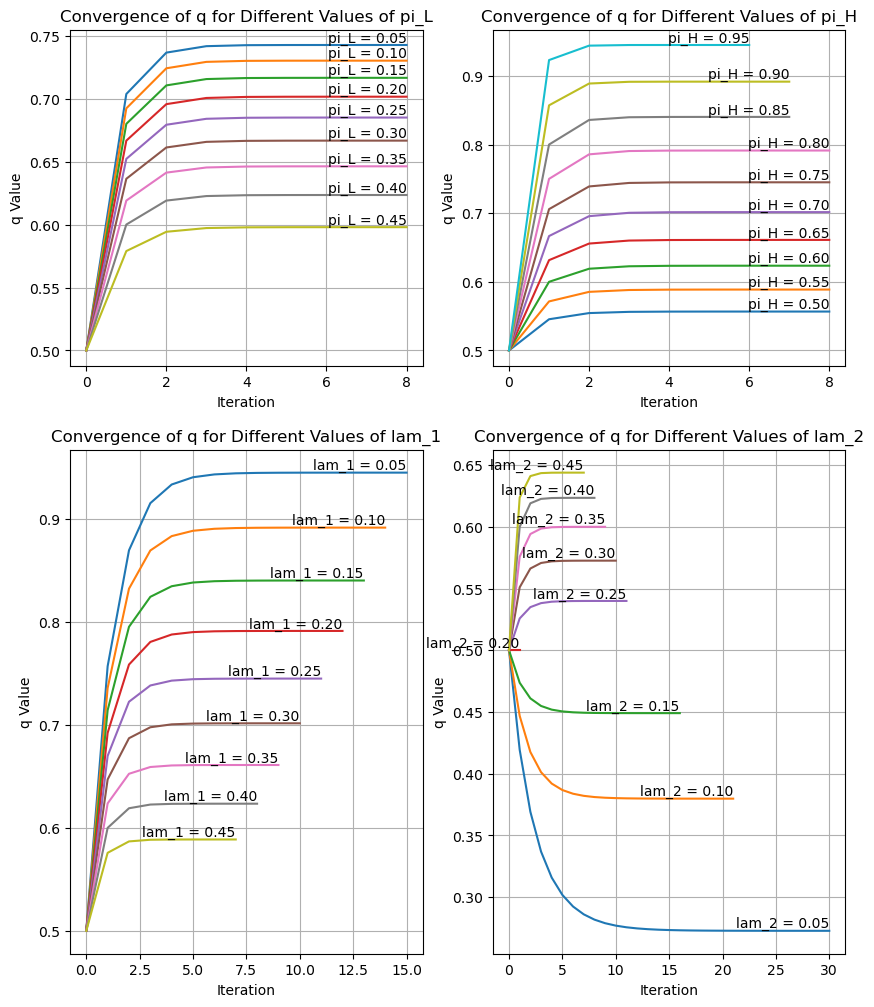

In [152]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 12), gridspec_kw={'height_ratios': [2, 3]})

convergence_results_pi_L_alternate = []
convergence_results_pi_H_alternate = []
convergence_results_lam_1_alternate = []
convergence_results_lam_2_alternate = []

# Plot for pi_L
ax1.set_xlabel('Iteration')
ax1.set_ylabel('q Value')
ax1.set_title('Convergence of q for Different Values of pi_L')
ax1.grid(True)

for pi_L in pi_L_values:
    investor = InvestorForecast()
    investor.par.pi_L = pi_L
    q_values_pi_L = investor.convergence(1, -1, False)
    convergence_results_pi_L_alternate.append((pi_L, q_values_pi_L))
    ax1.plot(q_values_pi_L, label=f'pi_L = {pi_L}')
    ax1.text(len(q_values_pi_L) - 1, q_values_pi_L[-1], f'pi_L = {pi_L:.2f}', verticalalignment='bottom', horizontalalignment='right')

# Plot for pi_H
ax2.set_xlabel('Iteration')
ax2.set_ylabel('q Value')
ax2.set_title('Convergence of q for Different Values of pi_H')
ax2.grid(True)

for pi_H in pi_H_values:
    investor = InvestorForecast()
    investor.par.pi_H = pi_H
    q_values_pi_H = investor.convergence(1, -1, False)
    convergence_results_pi_H_alternate.append((pi_H, q_values_pi_H))
    ax2.plot(q_values_pi_H, label=f'pi_H = {pi_H}')
    ax2.text(len(q_values_pi_H) - 1, q_values_pi_H[-1], f'pi_H = {pi_H:.2f}', verticalalignment='bottom', horizontalalignment='right')

# Plot for lam_1
ax3.set_xlabel('Iteration')
ax3.set_ylabel('q Value')
ax3.set_title('Convergence of q for Different Values of lam_1')
ax3.grid(True)

for lam_1 in lam_1_values:
    investor = InvestorForecast()
    investor.par.lam_1 = lam_1
    q_values_lam_1 = investor.convergence(1, -1, False)
    convergence_results_lam_1_alternate.append((lam_1, q_values_lam_1))
    ax3.plot(q_values_lam_1, label=f'lam_1 = {lam_1}')
    ax3.text(len(q_values_lam_1) - 1, q_values_lam_1[-1], f'lam_1 = {lam_1:.2f}', verticalalignment='bottom', horizontalalignment='right')

# Plot for lam_1
ax4.set_xlabel('Iteration')
ax4.set_ylabel('q Value')
ax4.set_title('Convergence of q for Different Values of lam_2')
ax4.grid(True)

for lam_2 in lam_2_values:
    investor = InvestorForecast()
    investor.par.lam_2 = lam_2
    q_values_lam_2 = investor.convergence(1, -1, False)
    convergence_results_lam_2_alternate.append((lam_2, q_values_lam_2))
    ax4.plot(q_values_lam_2, label=f'lam_2 = {lam_2}')
    ax4.text(len(q_values_lam_2) - 1, q_values_lam_2[-1], f'lam_2 = {lam_2:.2f}', verticalalignment='bottom', horizontalalignment='right')


plt.show()

_Changes in_ $\pi_L$\
A smaller value of $\pi_L$ indicates a small perceived probability of consecutive similar shocks happening, given model 1.\
Therefore, when $\pi_L$ is small and many consecutive alternating shocks happen, investor, all else equal, perceives model 1 to be more likely.\
\
_Changes in_ $\pi_H$\
A larger value of $\pi_H$ indicates a larger perceived probability of consecutive similar shocks happening, given model 2.\
Therefore, when $\pi_H$ is large and many consecutive alternating shocks happen, investor, all else equal, perceives model 1 to be more likely.\
Also, investor converges to this result faster than if $\pi_H$ is small.\
\
_Changes in_ $\lambda_1$\
A smaller value of $\lambda_1$ indicates a larger perceived probability of $s_t=s_{t+1}=1$, where model 1 governs earnings\
Therefore, when $\lambda_1$ is small and many consecutive alternating shocks happen, investor, all else equal, perceives model 1 to be more likely than if $\lambda_1$ is large\
Investor will take a longer time to converge to this result, than if $\lambda_1$ was larger.\
\
_Changes in_ $\lambda_2$\
A smaller value of $\lambda_2$ indicates a larger perceived probability of $s_t=s_{t+1}=2$, where model 2 governs earnings\
Therefore, when $\lambda_2$ is small and many consecutive alternating shocks happen, investor, all else equal, perceives model 1 to be more likely than if $\lambda_2$ is large\
Investor will take a longer time to converge to this result, than if $\lambda_2$ was larger.

**Simulation given reparameterization**

For an easier graphical representation, I am plotting the simulation given the parameters:\
$\pi_L = [0.05, 0.25, 0.45]$\
$\pi_H = [0.50, 0.75, 0.95]$\
$\lambda_1 = [0.05, 0.25, 0.45]$\
$\lambda_2 = [0.05, 0.25, 0.45]$\
\
To ensure the same draws for each parameter change in each simulation, np.random.set_state(state) is included in each for-loop.

Shock in period  1 = -1
Shock in period  2 = -1
Shock in period  3 = -1
Shock in period  4 =  1
Shock in period  5 = -1
Shock in period  6 =  1
Shock in period  7 = -1
Shock in period  8 = -1
Shock in period  9 = -1
Shock in period 10 = -1
Shock in period 11 =  1
Shock in period 12 = -1
Shock in period 13 = -1
Shock in period 14 =  1
Shock in period 15 =  1
Shock in period 16 = -1
Shock in period 17 =  1
Shock in period 18 =  1
Shock in period 19 = -1
Shock in period 20 = -1


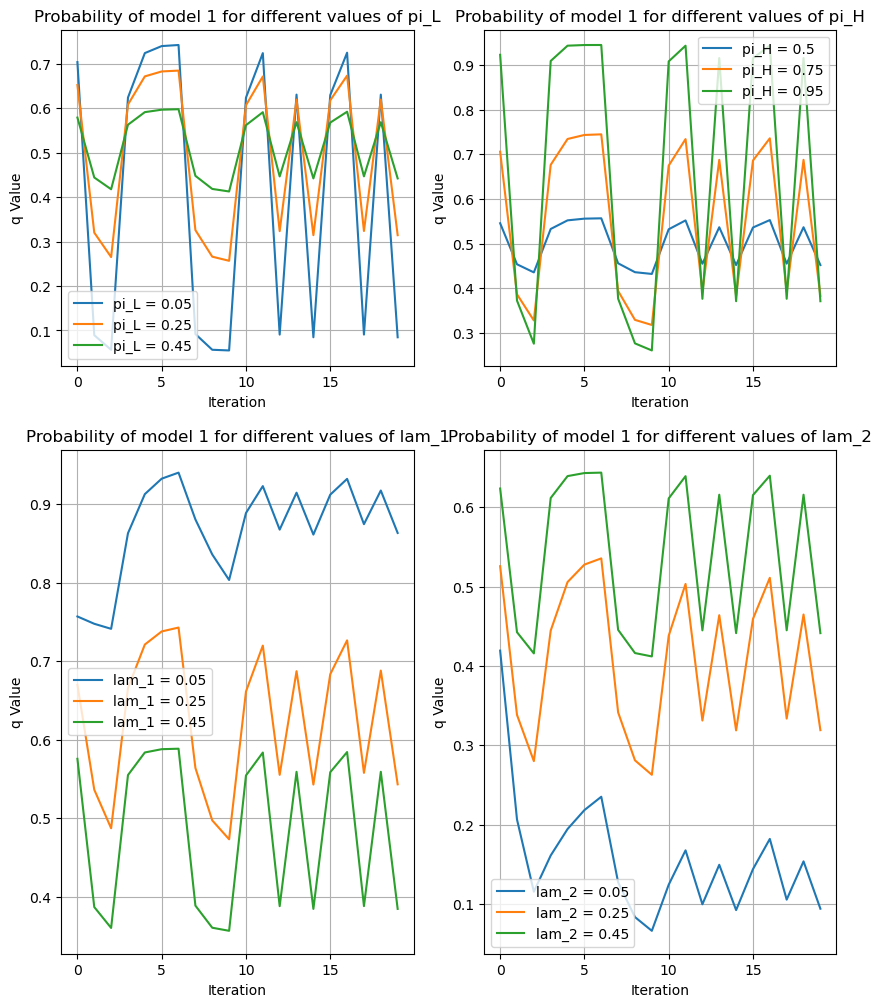

In [181]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 12), gridspec_kw={'height_ratios': [2, 3]})
sim_pi_L = [0.05, 0.25, 0.45]
sim_pi_H = [0.5, 0.75, 0.95]
sim_lam_1 = [0.05, 0.25, 0.45]
sim_lam_2 = [0.05, 0.25, 0.45]

sim_results_pi_L = []
sim_results_pi_H = []
sim_results_lam_1 = []
sim_results_lam_2 = []

# Plot for simulation given changes in pi_L
ax1.set_xlabel('Iteration')
ax1.set_ylabel('q Value')
ax1.set_title('Probability of model 1 for different values of pi_L')
ax1.grid(True)

for pi_L in sim_pi_L:
    np.random.set_state(state)
    investor = InvestorForecast()
    investor.par.pi_L = pi_L
    q_values_pi_L = investor.simulate(n, False)
    sim_results_pi_L.append((pi_L, q_values_pi_L))
    ax1.plot(q_values_pi_L, label=f'pi_L = {pi_L}')

# Plot for simulation given changes in pi_H
ax2.set_xlabel('Iteration')
ax2.set_ylabel('q Value')
ax2.set_title('Probability of model 1 for different values of pi_H')
ax2.grid(True)

for pi_H in sim_pi_H:
    np.random.set_state(state)
    investor = InvestorForecast()
    investor.par.pi_H = pi_H
    q_values_pi_H = investor.simulate(n, False)
    sim_results_pi_H.append((pi_H, q_values_pi_H))
    ax2.plot(q_values_pi_H, label=f'pi_H = {pi_H}')

# Plot for simulation given changes in lam_1
ax3.set_xlabel('Iteration')
ax3.set_ylabel('q Value')
ax3.set_title('Probability of model 1 for different values of lam_1')
ax3.grid(True)

for lam_1 in sim_lam_1:
    np.random.set_state(state)
    investor = InvestorForecast()
    investor.par.lam_1 = lam_1
    q_values_lam_1 = investor.simulate(n, False)
    sim_results_lam_1.append((lam_1, q_values_lam_1))
    ax3.plot(q_values_lam_1, label=f'lam_1 = {lam_1}')

# Plot for simulation given changes in lam_2
ax4.set_xlabel('Iteration')
ax4.set_ylabel('q Value')
ax4.set_title('Probability of model 1 for different values of lam_2')
ax4.grid(True)

for lam_2 in sim_lam_2:
    np.random.set_state(state)
    investor = InvestorForecast()
    investor.par.lam_2 = lam_2
    q_values_lam_2 = investor.simulate(n, False)
    sim_results_lam_2.append((lam_2, q_values_lam_2))
    ax4.plot(q_values_lam_2, label=f'lam_2 = {lam_2}')

np.random.set_state(state)
for i in range(n):
    print(f'Shock in period {i+1:2} = {np.random.choice([-1, 1]):2}')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

_Changes in_ $\pi_L$\
A smaller value of $\pi_L$ indicates a small perceived probability of consecutive similar shocks happening, given model 1.\
This means as $\pi_L$ gets larger, the investor perceives the probability of model 1 governing earnings to be more stable when shocks are randomly generated.\
In the case where $\pi_L$ is small, the variance of investor's perceived probability for model 1 is greater.\
\
_Changes in_ $\pi_H$\
A larger value of $\pi_H$ indicates a larger perceived probability of consecutive similar shocks happening, given model 2.\
Therefore, when $\pi_H$ is small and shocks are randomly generated, investor, all else equal, perceives the probability of model 1 to be more stable than if $\pi_H$ is large.\
\
_Changes in_ $\lambda_1$\
A smaller value of $\lambda_1$ indicates a larger perceived probability of $s_t=s_{t+1}=1$, where model 1 governs earnings\
Therefore, when $\lambda_1$ is small, the perceived probability of model 1 governing earnings is higher and less volatile, than if $\lambda_1$ is large, given random shocks.\
\
_Changes in_ $\lambda_2$\
A smaller value of $\lambda_2$ indicates a larger perceived probability of $s_t=s_{t+1}=2$, where model 2 governs earnings\
Therefore, when $\lambda_2$ is small the perceived probability of model 1 governing earnings is lower and less volatile, than if $\lambda_2$ is large, given random shocks.

# Conclusion

Add concise conclusion. 